### Bibliotecas

In [1]:
import pandas as pd
from datetime import datetime, date
from matplotlib import pyplot as plt
from scipy import stats
from patsy import dmatrices
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from math import sqrt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Importação dos Dados e Criação de Variáveis

In [2]:
dataset_dados = pd.read_excel('botafogo_previsao_estadio.xlsx')

In [3]:
dataset_dados = dataset_dados.sort_values(by='data').reset_index(drop=True)

##### Datas

In [4]:
dataset_dados['data'] = pd.to_datetime(dataset_dados['data'])

In [5]:
for i in range(len(dataset_dados)):
    dataset_dados.loc[i, 'dia_semana'] = dataset_dados['data'][i].weekday()
    dataset_dados.loc[i, 'hora'] = int(str(dataset_dados['horario'][0])[:2])
    dataset_dados.loc[i, 'minuto'] = int(str(dataset_dados['horario'][0])[3:5])

In [6]:
dataset_dados['mes'] = dataset_dados['data'].dt.month

In [7]:
dataset_dados['dia_mes'] = dataset_dados['data'].dt.day

##### Resultados de Jogos

In [8]:
dataset_dados['resultado_temporario'] = dataset_dados['gols_mandante'] - dataset_dados['gols_visitantes']

In [9]:
for i in range(len(dataset_dados)):
    if dataset_dados['resultado_temporario'][i] == 0:
        dataset_dados.loc[i, 'resultado_partida'] = 0
    elif dataset_dados['resultado_temporario'][i] > 0:
        dataset_dados.loc[i, 'resultado_partida'] = 1
    else:
        dataset_dados.loc[i, 'resultado_partida'] = -1

In [10]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == 1)
].index, 'resultado_partida'] = -1

In [11]:
dataset_dados.loc[dataset_dados[
    (dataset_dados['time_mandante'] != 'Botafogo') &
    (dataset_dados['resultado_partida'] == -1)
].index, 'resultado_partida'] = 1

Resultados Consecutivos

    Olhando para os últimos 5 jogos como vem sendo o "momento" do time:
        Vitória: 1 ponto
        Empate: 0 ponto
        Derrota: -1 ponto
        
    Valor Máximo: 5 pontos
    Valor Mínimo: -5 pontos

In [12]:
#RESULTADOS CONSECUTIVOS
    
for i in range(len(dataset_dados)):
    valor = dataset_dados['resultado_partida'].shift(5, fill_value=0)[i+0:5+i].sum()
    dataset_dados.loc[i, 'resultados_consecutivos'] = valor
    
#RESULTADO ÚLTIMO JOGO

for i in range(len(dataset_dados)):
    valor = dataset_dados['resultado_partida'].shift(1, fill_value=0)[i+0:5+i].sum()
    dataset_dados.loc[i, 'resultados_ultimo_jogo'] = valor

##### Gols, Colocação e Time Adversário

In [13]:
for i in range(len(dataset_dados)):
    if dataset_dados['time_mandante'][i] == 'Botafogo':
        dataset_dados.loc[i, 'gols_botafogo'] = dataset_dados['gols_mandante'][i]
        dataset_dados.loc[i, 'colocacao_botafogo'] = dataset_dados['colocacao_mandante'][i]
        dataset_dados.loc[i, 'colocacao_adversario'] = dataset_dados['colocacao_visitante'][i]
        dataset_dados.loc[i, 'time_adversario'] = dataset_dados['time_visitante'][i]
    else:
        dataset_dados.loc[i, 'gols_botafogo'] = dataset_dados['gols_visitantes'][i]
        dataset_dados.loc[i, 'colocacao_botafogo'] = dataset_dados['colocacao_visitante'][i]
        dataset_dados.loc[i, 'colocacao_adversario'] = dataset_dados['colocacao_mandante'][i]
        dataset_dados.loc[i, 'time_adversario'] = dataset_dados['time_mandante'][i] 
for i in range(len(dataset_dados)):
    valor = dataset_dados['gols_botafogo'].shift(5, fill_value=0)[i+0:5+i].sum()
    dataset_dados.loc[i, 'gols_botafogo_ultimos_jogos'] = valor

##### Percentual de Ocupacao

In [14]:
dataset_dados['percentual_ocupacao'] = round((dataset_dados['publico'] / dataset_dados['publico_max']) * 100, 2)

##### Jogos de Mando Vendido ou Compartilhado

In [15]:
dados_mando_vendido = dataset_dados[(dataset_dados['resultado_financeiro'] != dataset_dados['custo_botafogo'])]
index = dados_mando_vendido[~dados_mando_vendido['custo_botafogo'].isnull()].index

In [16]:
dataset_dados['mando_vendido_compartilhado'] = False
dataset_dados.loc[index, 'mando_vendido_compartilhado'] = True

##### Prejuízo ou Lucro

In [17]:
index = dataset_dados[dataset_dados['custo_botafogo'] <= 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[dataset_dados['custo_botafogo'] > 0].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

Competições Internacionais não possuem o borderô publicado a partir de certa data, portanto vamos considerar uma regra:

    Nunca houve prejuízo em jogos com 900000 reais de arrecadação

In [18]:
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] < 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = False
index = dataset_dados[(dataset_dados['custo_botafogo'].isnull()) &
              (dataset_dados['arrecadacao'] >= 900000)
             ].index
dataset_dados.loc[index, 'prejuizo_lucro'] = True

### Dados Usáveis para o Modelo e Tratamentos

In [19]:
dataset_dados = dataset_dados[dataset_dados['time_mandante'] == 'Botafogo']
dataset_dados = dataset_dados.reset_index(drop=True)

In [20]:
len(dataset_dados)

91

In [21]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'horario',
       'rodada', 'tipo_partida', 'publico', 'publico_max', 'arrecadacao',
       'despesas', 'impostos', 'resultado_financeiro', 'custo_botafogo',
       'anunciou_poupar', 'time_mandante', 'time_visitante',
       'estado_adversario', 'classico', 'eliminatorio', 'tecnico_botafogo',
       'colocacao_mandante', 'colocacao_visitante', 'gols_mandante',
       'gols_visitantes', 'dia_semana', 'hora', 'minuto', 'mes', 'dia_mes',
       'resultado_temporario', 'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'gols_botafogo', 'colocacao_botafogo',
       'colocacao_adversario', 'time_adversario',
       'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro'],
      dtype='object')

In [22]:
dataset_dados = dataset_dados.drop(columns=['resultado_temporario', 'gols_visitantes', 'gols_mandante',
                                           'colocacao_visitante', 'colocacao_mandante', 'time_visitante', 'time_mandante',
                                           'custo_botafogo', 'resultado_financeiro', 'impostos', 'despesas', 'arrecadacao',
                                            'publico_max', 'publico', 'gols_botafogo', 'horario'])

In [23]:
dataset_dados.columns

Index(['ano_campeonato', 'campeonato', 'fase', 'estádio', 'data', 'rodada',
       'tipo_partida', 'anunciou_poupar', 'estado_adversario', 'classico',
       'eliminatorio', 'tecnico_botafogo', 'dia_semana', 'hora', 'minuto',
       'mes', 'dia_mes', 'resultado_partida', 'resultados_consecutivos',
       'resultados_ultimo_jogo', 'colocacao_botafogo', 'colocacao_adversario',
       'time_adversario', 'gols_botafogo_ultimos_jogos', 'percentual_ocupacao',
       'mando_vendido_compartilhado', 'prejuizo_lucro'],
      dtype='object')

In [24]:
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'] == 'SIM'].index, 'anunciou_poupar'] = True
dataset_dados.loc[dataset_dados[dataset_dados['anunciou_poupar'].isnull()].index, 'anunciou_poupar'] = False
dataset_dados.loc[dataset_dados[dataset_dados['classico'] == 'SIM'].index, 'classico'] = True
dataset_dados.loc[dataset_dados[dataset_dados['classico'].isnull()].index, 'classico'] = False
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'] == 'SIM'].index, 'eliminatorio'] = True
dataset_dados.loc[dataset_dados[dataset_dados['eliminatorio'].isnull()].index, 'eliminatorio'] = False

In [25]:
len(dataset_dados.columns)

27

In [26]:
dataset_dados = pd.get_dummies(dataset_dados, columns=['campeonato', 'estádio', 'tipo_partida', 'estado_adversario',
                                                       'tecnico_botafogo', 'time_adversario', 'fase'])

In [27]:
dataset_dados = dataset_dados.astype({'anunciou_poupar': bool,
                                      'classico': bool,
                                      'eliminatorio': bool,
                                       'prejuizo_lucro': bool
                                     })

In [28]:
dataset_previsao = dataset_dados[dataset_dados['data'] >= pd.to_datetime(date.today())]
dataset_dados = dataset_dados[dataset_dados['data'] < pd.to_datetime(date.today())]
dataset_dados = dataset_dados.drop(columns=['data'])
dataset_previsao = dataset_previsao.drop(columns=['data'])
dataset_dados = dataset_dados.reset_index(drop=True)

In [29]:
dataset_dados.head()

,ano_campeonato,rodada,anunciou_poupar,classico,eliminatorio,dia_semana,hora,minuto,mes,dia_mes,...,time_adversario_Ypiranga,fase_fase de grupos,fase_final - taça rio,fase_liga,fase_oitavas-de-final,fase_quartas-de-final,fase_segunda fase,fase_semi-final,fase_semi-final - taça rio,fase_terceira fase
0,2022,1,False,True,True,0.0,16.0,0.0,3,21,...,False,False,False,False,False,False,False,True,False,False
1,2022,1,False,False,False,6.0,16.0,0.0,4,10,...,False,False,False,True,False,False,False,False,False,False
2,2022,4,False,False,False,6.0,16.0,0.0,5,1,...,False,False,False,True,False,False,False,False,False,False
3,2022,2,False,False,True,3.0,16.0,0.0,5,12,...,False,False,False,False,False,False,False,False,False,True
4,2022,6,False,False,False,6.0,16.0,0.0,5,15,...,False,False,False,True,False,False,False,False,False,False


In [30]:
len(dataset_dados)

75

In [31]:
dataset_dados.isnull()

,ano_campeonato,rodada,anunciou_poupar,classico,eliminatorio,dia_semana,hora,minuto,mes,dia_mes,...,time_adversario_Ypiranga,fase_fase de grupos,fase_final - taça rio,fase_liga,fase_oitavas-de-final,fase_quartas-de-final,fase_segunda fase,fase_semi-final,fase_semi-final - taça rio,fase_terceira fase
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
72,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [32]:
dataset_dados.to_csv('dados_modelo_final.csv', index=False)

### Datasets Modelos

Haverão Três Modelos, cada um olhando para uma variável alvo específica, as variáveis alvo serão:

    - percentual_ocupacao: Olhando para tentarmos prever a quantidade de pessoas que irão aos jogos
    - prejuizo_lucro: Olhando para tentarmos prever se o jogo foi rentável (olhando apenas para o contexto do jogo)
    - resultado_partida: Olhando para tentarmos prever o resultado do jogo (Derrota, Vitória ou Empate
    
Sendo assim cada modelo terá seu dataset específico, pois as variáveis alvo não são passíveis de serem utilizadas nos modelos que não sejam os seus por não serem valores disponíveis para a previsão antes do evento acontecer, chamaremos essas varíaveis de indisponíveis.

In [33]:
dados_modelo_percentual_ocupacao = dataset_dados.drop(columns=['prejuizo_lucro', 'resultado_partida']).copy()
dados_modelo_prejuizo_lucro = dataset_dados.drop(columns=['percentual_ocupacao', 'resultado_partida']).copy()
dados_modelo_resultado_partida = dataset_dados.drop(columns=['percentual_ocupacao', 'prejuizo_lucro']).copy()

### Análise Exploratória

##### Funções Úteis

In [34]:
def concentracao_valores (dados, coluna):
    if len(dados[coluna].unique()) > 3:        
        print(dados[coluna].describe())
    else:        
        print(dados[coluna].value_counts())

In [35]:
def correlacao_modelos (dados, coluna):
    print('Menores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values().head(7))
    print('======================')
    print('Maiores Valores')
    print('----------------------')
    print(dados.corr()[coluna].sort_values(ascending=False).head(7))

In [36]:
def visualizacoes (dados, coluna, label):
    if len(dados[coluna].unique()) > 3: 
        fig, ax = plt.subplots()
        ax.hist(dados[coluna])
        ax.set_xlabel(label)
        ax.set_title('Análise Visual - Histograma - '+label)
        plt.show()

In [37]:
def taxas_erro (valores_reais, valores_previstos):
    #RMSE
    rmse = sqrt(mean_squared_error(valores_reais, valores_previstos))
    print('Erro médio quadrático: ', rmse)
    #MAE
    mae = mean_absolute_error(valores_reais, valores_previstos)
    print('Erro médio absoluto: ', mae)

Esse artigo me ajudou com a tunagem dos hiperparâmetros:

    - https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [38]:
def tunning_hiperpametros (modelo, X_train, y_train):
    
    print('Testando Variáveis: max_depth, min_child_weight')
    
    param_test = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,6,2),
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
        
    max_depth = gsearch.best_params_['max_depth']
    min_child_weight = gsearch.best_params_['min_child_weight']
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis:gamma')
    
    param_test = {
     'gamma':[i/10.0 for i in range(0,5)],
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = 0 , subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    gamma = gsearch.best_params_['gamma']
    
    print('-----------------------------')  
    
    print('Testando Variáveis: subsample, colsample_bytree')
    
    param_test = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  
    
    print('Testando Variáveis: reg_alpha')
    
    param_test = {
     'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
    }
    
    gsearch = GridSearchCV(estimator = modelo(
                    learning_rate=0.01, max_depth=max_depth, n_estimators=200, n_jobs=-1, random_state=1, seed=42,
                    min_child_weight=min_child_weight, gamma = gamma, subsample = gsearch.best_params_['subsample'],
                    colsample_bytree = gsearch.best_params_['colsample_bytree'], scale_pos_weight = 1
                   ), 
                    param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=10)      
    gsearch.fit(X_train, y_train)
    
    print('Melhores valores: ', gsearch.best_params_)
    
    print('-----------------------------')  

##### Modelo 1

In [39]:
concentracao_valores(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

count    75.000000
mean     44.833467
std      23.721517
min       8.140000
25%      26.485000
50%      41.750000
75%      63.050000
max      91.780000
Name: percentual_ocupacao, dtype: float64


In [40]:
correlacao_modelos(dados_modelo_percentual_ocupacao, 'percentual_ocupacao')

Menores Valores
----------------------
campeonato_carioca              -0.519582
estado_adversario_RJ            -0.397612
time_adversario_Portuguesa-RJ   -0.312850
mando_vendido_compartilhado     -0.288932
anunciou_poupar                 -0.284745
estádio_Raulino de Oliveira     -0.254809
time_adversario_Audax Rio       -0.253966
Name: percentual_ocupacao, dtype: float64
Maiores Valores
----------------------
percentual_ocupacao                1.000000
mes                                0.451071
campeonato_serie a                 0.383254
tecnico_botafogo_Bruno Lage        0.376013
rodada                             0.290370
tecnico_botafogo_Cláudio Caçapa    0.252618
estádio_Nilton Santos              0.227854
Name: percentual_ocupacao, dtype: float64


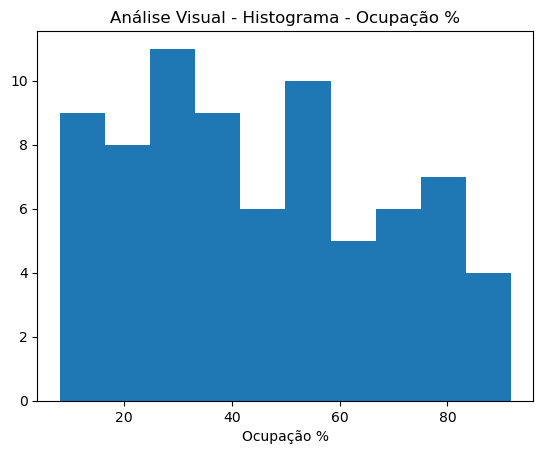

In [41]:
visualizacoes(dados_modelo_percentual_ocupacao, 'percentual_ocupacao', 'Ocupação %')

##### Modelo 2 

In [42]:
concentracao_valores(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

prejuizo_lucro
True     39
False    36
Name: count, dtype: int64


In [43]:
correlacao_modelos(dados_modelo_prejuizo_lucro, 'prejuizo_lucro')

Menores Valores
----------------------
eliminatorio                    -0.411726
anunciou_poupar                 -0.386976
campeonato_carioca              -0.346580
tipo_partida_volta              -0.329739
time_adversario_Portuguesa-RJ   -0.212459
estádio_Luso Brasileiro         -0.212459
fase_segunda fase               -0.212459
Name: prejuizo_lucro, dtype: float64
Maiores Valores
----------------------
prejuizo_lucro         1.000000
tipo_partida_liga      0.411726
campeonato_serie a     0.358115
mes                    0.298085
fase_fase de grupos    0.283315
rodada                 0.283177
classico               0.245535
Name: prejuizo_lucro, dtype: float64


##### Modelo 3

In [44]:
concentracao_valores(dados_modelo_resultado_partida, 'resultado_partida')

resultado_partida
 1.0    39
-1.0    21
 0.0    15
Name: count, dtype: int64


In [45]:
correlacao_modelos(dados_modelo_resultado_partida, 'resultado_partida')

Menores Valores
----------------------
tecnico_botafogo_Lúcio Flávio   -0.322590
rodada                          -0.305442
classico                        -0.296770
time_adversario_Flamengo        -0.293763
mes                             -0.254602
estado_adversario_MT            -0.238208
time_adversario_Cuiabá-MT       -0.238208
Name: resultado_partida, dtype: float64
Maiores Valores
----------------------
resultado_partida              1.000000
resultados_ultimo_jogo         0.589292
gols_botafogo_ultimos_jogos    0.315000
ano_campeonato                 0.306034
eliminatorio                   0.232689
dia_mes                        0.231696
tipo_partida_volta             0.209403
Name: resultado_partida, dtype: float64


### Modelagem

##### Modelo 1

In [46]:
X = dados_modelo_percentual_ocupacao.drop(columns=['percentual_ocupacao']).copy()
y = dados_modelo_percentual_ocupacao[['percentual_ocupacao']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [48]:
tunning_hiperpametros(XGBRegressor, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [50]:
model = XGBRegressor(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0.0, subsample = 0.6, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05)
model.fit(X_train, y_train, 
          early_stopping_rounds=10,
          eval_set=eval_set, eval_metric='rmse', verbose = 1)

[0]	validation_0-rmse:22.66882
[1]	validation_0-rmse:22.60791
[2]	validation_0-rmse:22.51185
[3]	validation_0-rmse:22.50260
[4]	validation_0-rmse:22.44313
[5]	validation_0-rmse:22.33219
[6]	validation_0-rmse:22.23477
[7]	validation_0-rmse:22.20786
[8]	validation_0-rmse:22.12647
[9]	validation_0-rmse:22.12627
[10]	validation_0-rmse:22.05401
[11]	validation_0-rmse:21.98443
[12]	validation_0-rmse:21.94146
[13]	validation_0-rmse:21.87340
[14]	validation_0-rmse:21.80987
[15]	validation_0-rmse:21.77272
[16]	validation_0-rmse:21.77648
[17]	validation_0-rmse:21.73843
[18]	validation_0-rmse:21.72351
[19]	validation_0-rmse:21.67427
[20]	validation_0-rmse:21.59558
[21]	validation_0-rmse:21.53385
[22]	validation_0-rmse:21.49844
[23]	validation_0-rmse:21.49514
[24]	validation_0-rmse:21.48751
[25]	validation_0-rmse:21.41046
[26]	validation_0-rmse:21.30169
[27]	validation_0-rmse:21.31045
[28]	validation_0-rmse:21.28613
[29]	validation_0-rmse:21.22192
[30]	validation_0-rmse:21.18044
[31]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [51]:
model.feature_importances_

array([0.01222534, 0.01199414, 0.01956961, 0.00924823, 0.02022652,
       0.01394219, 0.        , 0.        , 0.03239765, 0.01642683,
       0.0122997 , 0.01195388, 0.02404445, 0.01078195, 0.01644286,
       0.00045368, 0.04774002, 0.01631664, 0.00720533, 0.02230491,
       0.04023426, 0.00591411, 0.00129392, 0.        , 0.00617994,
       0.00123654, 0.0115292 , 0.01625912, 0.        , 0.01327785,
       0.        , 0.01951195, 0.01896449, 0.        , 0.01095991,
       0.        , 0.01098615, 0.        , 0.00922944, 0.        ,
       0.00118952, 0.01390412, 0.01384992, 0.        , 0.        ,
       0.0053999 , 0.01856548, 0.05154458, 0.01403677, 0.01067845,
       0.01805838, 0.01406633, 0.0227995 , 0.02085852, 0.01562491,
       0.03332138, 0.01559775, 0.01353483, 0.01211662, 0.01193215,
       0.01065114, 0.        , 0.00928882, 0.        , 0.        ,
       0.00211674, 0.        , 0.        , 0.        , 0.00017623,
       0.01285718, 0.        , 0.        , 0.01601531, 0.00665

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

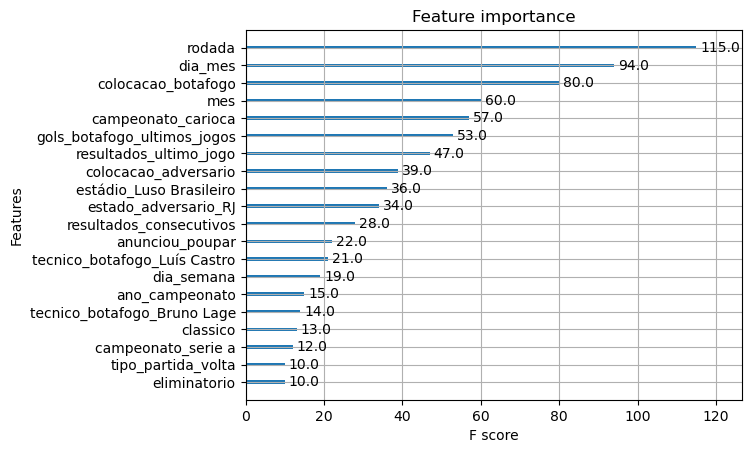

In [52]:
plot_importance(model, max_num_features=20)

In [53]:
score = model.score(X_train, y_train)  
score

0.6630197572164036

In [54]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

15

Text(0.5, 1.0, 'Previsão Ocupação')

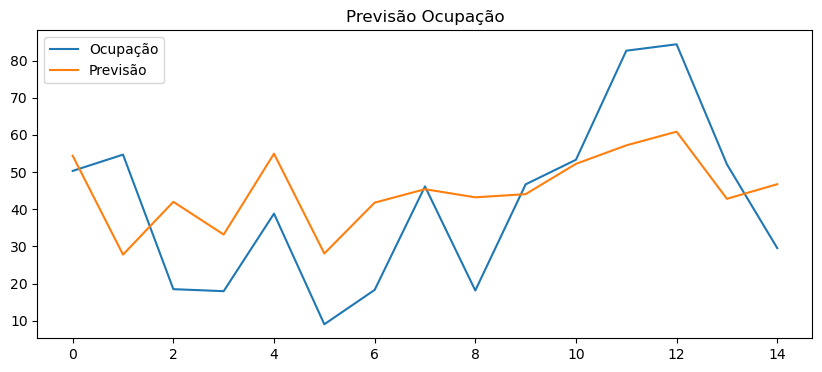

In [55]:
y_test = y_test.reset_index(drop=True)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test, label='Ocupação')
ax.plot(predictions, label='Previsão')
ax.legend()
ax.set_title("Previsão Ocupação")

In [56]:
taxas_erro(y_test, predictions)

Erro médio quadrático:  18.116246740035383
Erro médio absoluto:  15.56399977620443


##### Previsões

In [57]:
dataset_previsao_modelo = dataset_previsao.drop(columns=['percentual_ocupacao', 'prejuizo_lucro', 'resultado_partida']
                                               ).copy().reset_index(drop=True).loc[:0]

In [58]:
model.predict(dataset_previsao_modelo)

array([55.472332], dtype=float32)

##### Modelo 2

In [59]:
dados_modelo_prejuizo_lucro = dados_modelo_prejuizo_lucro[~dados_modelo_prejuizo_lucro['prejuizo_lucro'].isna() == True].reset_index(drop=True)

In [60]:
X = dados_modelo_prejuizo_lucro.drop(columns=['prejuizo_lucro']).copy()
y = dados_modelo_prejuizo_lucro[['prejuizo_lucro']]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [62]:
tunning_hiperpametros(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.1}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.8, 'subsample': 0.8}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [63]:
model = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0.1, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1,
                    reg_alpha= 1)

model.fit(X_train, y_train, 
          early_stopping_rounds=10,
          eval_set=eval_set, eval_metric='auc', verbose = 1)

[0]	validation_0-auc:0.44643
[1]	validation_0-auc:0.71429
[2]	validation_0-auc:0.75000
[3]	validation_0-auc:0.68750
[4]	validation_0-auc:0.66964
[5]	validation_0-auc:0.75000
[6]	validation_0-auc:0.75000
[7]	validation_0-auc:0.76786
[8]	validation_0-auc:0.78571
[9]	validation_0-auc:0.85714
[10]	validation_0-auc:0.85714
[11]	validation_0-auc:0.85714
[12]	validation_0-auc:0.85714
[13]	validation_0-auc:0.85714
[14]	validation_0-auc:0.85714
[15]	validation_0-auc:0.85714
[16]	validation_0-auc:0.85714
[17]	validation_0-auc:0.85714
[18]	validation_0-auc:0.83929


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, random_state=1, ...)

In [64]:
model.feature_importances_

array([0.06778661, 0.09016983, 0.17181486, 0.        , 0.04285517,
       0.01357862, 0.        , 0.        , 0.06877469, 0.03742366,
       0.0550073 , 0.01111706, 0.06045215, 0.03510184, 0.00742288,
       0.        , 0.11336628, 0.        , 0.        , 0.        ,
       0.13127857, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.07443616, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01941427, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

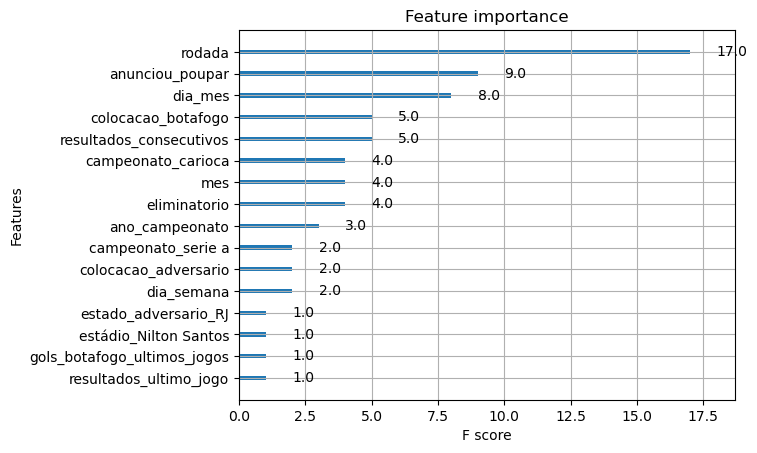

In [65]:
plot_importance(model, max_num_features=20)

In [66]:
score = model.score(X_train, y_train)  
score

0.5333333333333333

In [67]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

15

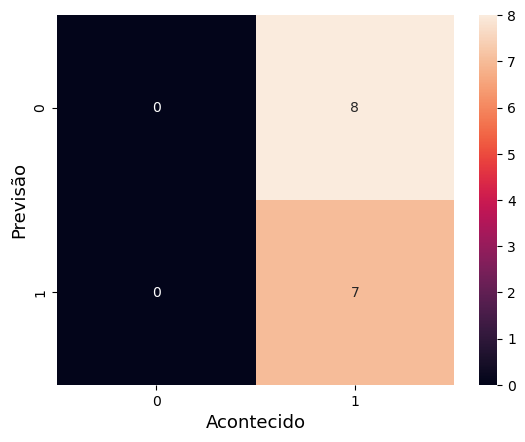

In [68]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Previsão',fontsize=13)
plt.xlabel('Acontecido',fontsize=13)
plt.show()

In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         8
        True       0.47      1.00      0.64         7

    accuracy                           0.47        15
   macro avg       0.23      0.50      0.32        15
weighted avg       0.22      0.47      0.30        15



##### Previsões

In [70]:
model.predict(dataset_previsao_modelo)

array([1])

##### Modelo 3

In [71]:
X = dados_modelo_resultado_partida.drop(columns=['resultado_partida']).copy()
y = dados_modelo_resultado_partida[['resultado_partida']]

In [72]:
y.loc[y[y['resultado_partida'] == -1].index, 'resultado_partida'] = 2

In [73]:
y['resultado_partida'] = y['resultado_partida'].astype(int)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(X_test, y_test)]

In [75]:
tunning_hiperpametros(XGBClassifier, X_train, y_train)

Testando Variáveis: max_depth, min_child_weight
Melhores valores:  {'max_depth': 3, 'min_child_weight': 1}
-----------------------------
Testando Variáveis:gamma
Melhores valores:  {'gamma': 0.0}
-----------------------------
Testando Variáveis: subsample, colsample_bytree
Melhores valores:  {'colsample_bytree': 0.6, 'subsample': 0.6}
-----------------------------
Testando Variáveis: reg_alpha
Melhores valores:  {'reg_alpha': 1e-05}
-----------------------------


In [76]:
model = XGBClassifier(verbosity=0, learning_rate=0.01, max_depth=3, n_estimators=10000, n_jobs=-1, random_state=1,
                    min_child_weight=1, gamma = 0., subsample = 0.6, colsample_bytree = 0.6, scale_pos_weight = 1,
                    reg_alpha= 1e-05)

model.fit(X_train, y_train, 
          early_stopping_rounds=10,
          eval_set=eval_set, eval_metric='auc', verbose = 1)

[0]	validation_0-auc:0.75667
[1]	validation_0-auc:0.80778
[2]	validation_0-auc:0.79667
[3]	validation_0-auc:0.74278
[4]	validation_0-auc:0.71611
[5]	validation_0-auc:0.72000
[6]	validation_0-auc:0.76889
[7]	validation_0-auc:0.75778
[8]	validation_0-auc:0.75167
[9]	validation_0-auc:0.73611
[10]	validation_0-auc:0.76833
[11]	validation_0-auc:0.74944


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10000, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [77]:
model.feature_importances_

array([0.03315283, 0.05421517, 0.064703  , 0.0271177 , 0.06608608,
       0.0255305 , 0.        , 0.        , 0.05173093, 0.07487902,
       0.03139681, 0.11408068, 0.04419505, 0.04064449, 0.06694315,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01442127, 0.05626998, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0382084 , 0.03281348, 0.        , 0.        ,
       0.04578095, 0.01596269, 0.        , 0.        , 0.        ,
       0.02842354, 0.        , 0.01861742, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

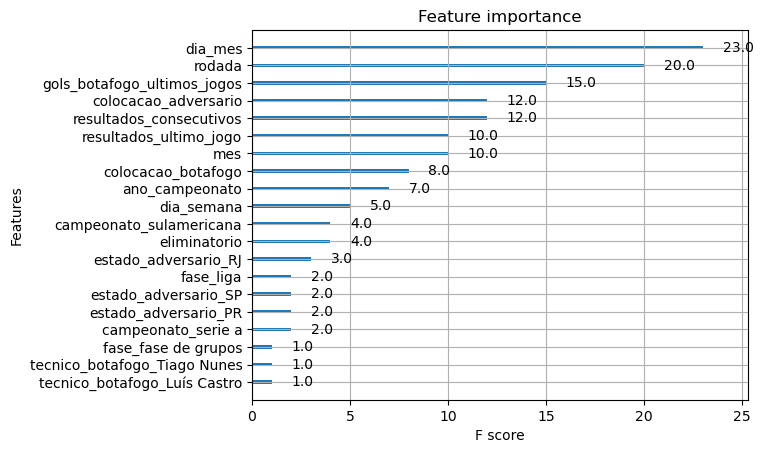

In [78]:
plot_importance(model, max_num_features=20)

In [79]:
score = model.score(X_train, y_train)  
score

0.7

In [80]:
y_pred = model.predict(X_test)
predictions = [round(value, 2) for value in y_pred]
len(predictions)

15

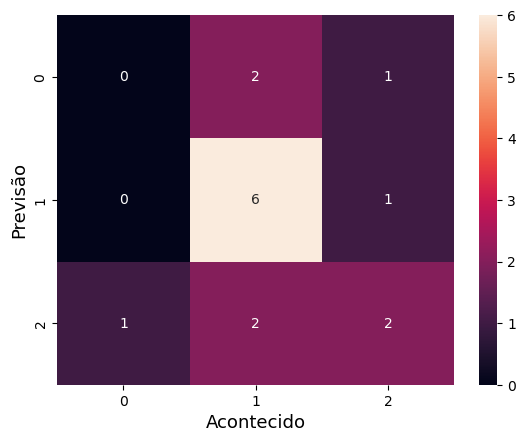

In [81]:
sns.heatmap(confusion_matrix(y_test, predictions), 
            annot=True,
            fmt='g')
plt.ylabel('Previsão',fontsize=13)
plt.xlabel('Acontecido',fontsize=13)
plt.show()

In [82]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.60      0.86      0.71         7
           2       0.50      0.40      0.44         5

    accuracy                           0.53        15
   macro avg       0.37      0.42      0.38        15
weighted avg       0.45      0.53      0.48        15



##### Previsões

In [83]:
model.predict(dataset_previsao_modelo)

array([2], dtype=int64)